# E5 - Prophet

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [73]:
#Paquetes necesarios
#!pip install pystan==2.19.1.1

In [74]:
#conda install -c conda-forge prophet

In [56]:
# Importar librerías

import pandas as pd
import numpy as np


%matplotlib inline

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
from pandas import DatetimeIndex

In [7]:
# Leer data
df = pd.read_csv("DataSet/example_retail_sales.csv")

# Información del dataframe
df.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [8]:
df.describe ()

,y
count,293.000000
mean,308971.310580
std,86084.323897
min,146376.000000
25%,234503.000000
50%,314051.000000
75%,375795.000000
max,518253.000000


In [9]:
# Ajuste de Dataframe para que ds tenga formato fecha
df.dtypes
df['ds'] = pd.DatetimeIndex(df['ds'])
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

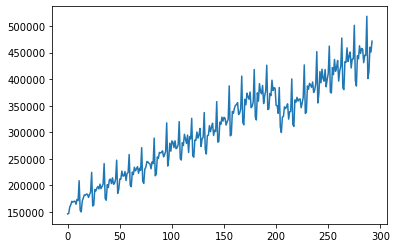

In [10]:
df['y'].plot()

COMENTARIO: En general, se tiene una serie creciente con comportamientos estacionales y un cambio de tendencia aaproximadamente a partir del dato 200 (es decir, del año 2009).

# Standardize the dataset using Numpy

In [29]:
df['log_y'] = np.log(df['y'])
df_log=df.iloc[:,[0,2]]
df_log.columns = ['time', 'log_y']
df_log.head()

,time,log_y
0,1992-01-01,11.893934
1,1992-02-01,11.898725
2,1992-03-01,11.978770
3,1992-04-01,12.005601
4,1992-05-01,12.043954


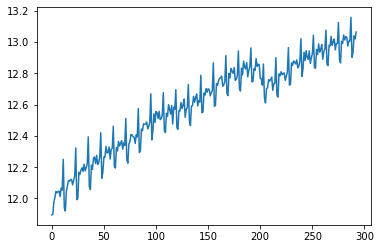

In [30]:
#df.log_y.plot()
df_log.log_y.plot()

COMENTARIO: Al estandarizar los datos aplicando logaritmo natural, se observa un comporatmiento similar al de la serie original.

La ventaja de transformar utilizando el logaritmo natural es que la diferencia de ellos es aproximadamente igual a la variación porcentual de la serie en los niveles originales.

# Train Model

In [32]:
df_log.columns = ['ds', 'y']
m = Prophet()
m.fit(df_log)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forcast 6 months future

In [35]:
future = m.make_future_dataframe(periods=6, freq='MS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
293,2016-06-01,13.055177,13.035317,13.074212
294,2016-07-01,13.056140,13.035196,13.076525
295,2016-08-01,13.076720,13.056645,13.095984
296,2016-09-01,13.009710,12.988890,13.029944
297,2016-10-01,13.048742,13.028287,13.069107
298,2016-11-01,13.053221,13.030572,13.075388


### Plotting the Forecast

A continuación se muestran las proyecciones del modelo, tanto para los datos originales como para los 6 meses adicionales de pronóstico:

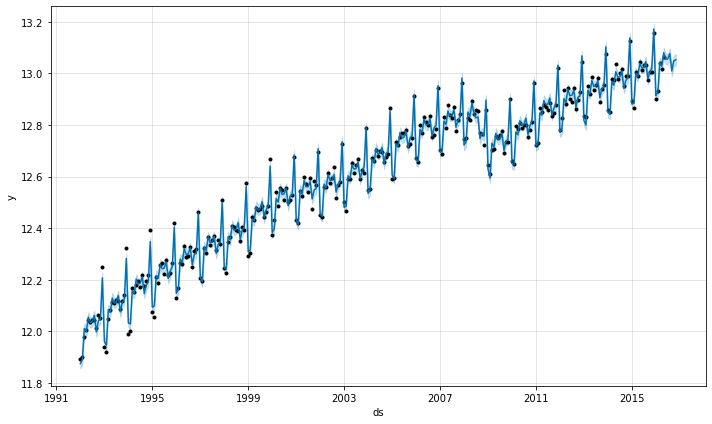

In [36]:
m.plot(forecast);

Haciendo zoom a los últimos doce meses, tenemos:

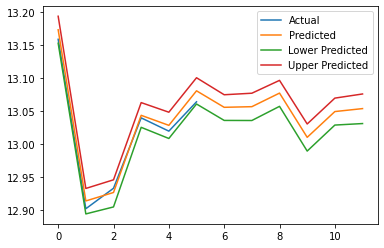

In [37]:
y_true = df_log['y'][-6:].values
y_pred = forecast['yhat'][-12:].values
y_pred_lower = forecast['yhat_lower'][-12:].values
y_pred_upper = forecast['yhat_upper'][-12:].values

pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.plot(y_pred_lower, label='Lower Predicted')
pyplot.plot(y_pred_upper, label='Upper Predicted')
pyplot.legend()
pyplot.show()

COMENTARIO: Los datos de los últimos 6 meses reales (línea azul) se encuentran dentro del intervalo de proyección del modelo (líneas roja y verde). Así mismo, la línea naranja muestra los datos proyectados de los últimos 6 meses y para los próximos 6 meses.

### Decomposing the Forecast 

En lo que sigue se detallan los componentes de tendencia y estacionalidad de la proyección del modelo:

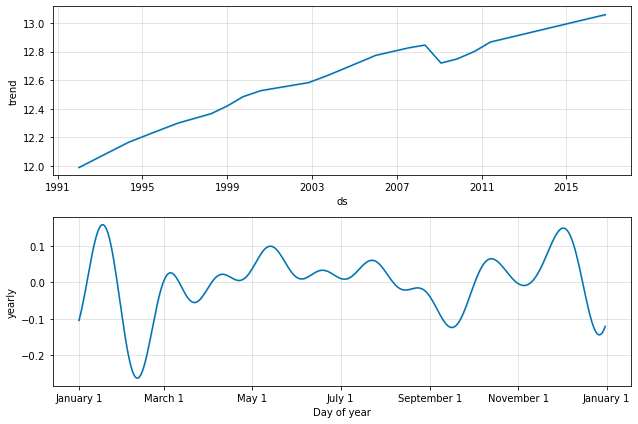

In [38]:
m.plot_components(forecast);

COMENTARIO 1: En lo que respecta a la tendencia, se observa una tendencia creciente con un ajuste de nivel a partir del año 2009. 

COMENTARIO 2: Frente a la estacionalidad, se observa que las ventas tienen mejor comportamiento en los meses de enero y de diciembre de cada año; así mismo, el mes de febrero muestra el nivel de ventas más bajo durante el año.

### Cross-validation

El cross validation se realiza para un horizonte de proyección de 6 meses, utilizando una base de entrenamiento de 17 años (70% de los datos) y agregando en cada simulación periodos de 3 meses (mitad del horizonte de proyección):

In [68]:
from prophet.diagnostics import cross_validation

cutoffs = pd.date_range(start='2009-01-01', end='2015-12-01', freq='3MS')
print(cutoffs)
DatetimeIndex(['2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
                '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
              '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
              '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01'
              ],
              dtype='datetime64[ns]', freq='3MS')


df_cv = cross_validation(model=m, horizon='180 days', cutoffs=cutoffs)


DatetimeIndex(['2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01'],
              dtype='datetime64[ns]', freq='3MS')


Los resultados de las 14 iteraciones son:

In [70]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,0.002481,0.049814,0.041180,0.003210,0.002411,0.003214,0.380952
1,59 days,0.003819,0.061795,0.047965,0.003742,0.001991,0.003744,0.431973
2,60 days,0.004311,0.065656,0.051937,0.004047,0.002114,0.004051,0.404762
3,61 days,0.002104,0.045867,0.041220,0.003182,0.002600,0.003183,0.285714
4,62 days,0.002123,0.046072,0.040941,0.003177,0.003454,0.003178,0.357143
5,90 days,0.003272,0.057204,0.045039,0.003514,0.003454,0.003516,0.448980
6,91 days,0.003055,0.055269,0.041418,0.003230,0.002347,0.003233,0.500000
7,92 days,0.002103,0.045862,0.036654,0.002862,0.002008,0.002867,0.428571
8,120 days,0.002714,0.052096,0.039511,0.003081,0.001610,0.003083,0.459184
9,121 days,0.002973,0.054527,0.042301,0.003295,0.002003,0.003298,0.428571


In [71]:
performance_metrics(data_cv).describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,140,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,200 days 19:01:42.857142,0.004550,0.066732,0.054555,0.004243,0.003192,0.004250,0.332813
std,95 days 09:41:37.996133,0.001337,0.009880,0.008452,0.000654,0.000754,0.000658,0.104618
min,34 days 00:00:00,0.002162,0.046501,0.036333,0.002846,0.001751,0.002848,0.187500
25%,117 days 18:00:00,0.003460,0.058826,0.048030,0.003728,0.002647,0.003732,0.250000
50%,201 days 12:00:00,0.004332,0.065816,0.054305,0.004216,0.003137,0.004217,0.312500
75%,284 days 00:00:00,0.005523,0.074315,0.060767,0.004721,0.003617,0.004733,0.437500
max,360 days 00:00:00,0.008554,0.092490,0.078259,0.006085,0.005479,0.006103,0.562500


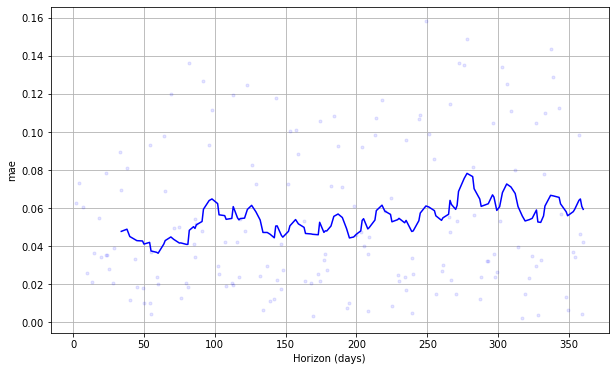

In [76]:
plot_cross_validation_metric(data_cv, metric='mae');

CONCLUSIÓN: Luego de realizar el cross-validation y tomando como medida de desempeño el Error Absoluto Medio (MAE), se observa que la proyección de las ventas oscila entre 3.6% y 7.8%, con media de 5,4%.